<a href="https://colab.research.google.com/github/prathamrg/OpenCityHackathon_TreeCoverAreaChangeMonitoring/blob/main/OpenCity_Climate_Hackathon_Tree_Cover_Change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Notebook Developed during the Open City Climate Hackathon in Bengaluru, India in August 2025 conducted with the following objective:**

"To collate data from a range of sources (including ones which are typically not collected by city agencies frequently, but are essential for measuring key outcome indicators) for a few selected climate action KPIs for the city (derived from Bengaluru Climate Action Plan - BCAP)• To analyse data to measure the outcomes of the selected KPIs to track the progress of climate actions implemented in the city• To visualize the measured outcomes in a user-friendly interface, which could be plugged into existing CAC-MER dashboards (if any)"

**The specific KPI chosen by our team was:**
Area of tree canopy cover – Annual change in the city’s tree canopy cover (‘Tree canopy cover’ refers to the layer of leaves, branches, and stems of trees that, when viewed from above, covers the ground)

**Our team comprises of the following members:**

Pratham R. Goel (Lead Data Scientist at Sustainability and Transition Finance Insights Team, HSBC)

Ayush Bhosle (Data Analyst at Sustainability and Transition Finance Insights Team, HSBC)

Srivalli (Independent GIS Expert)

Karthik (Student of Public Policy Studies)

With Expert Support from: Ganesh (GIS Expert at World Resources Institute)

The Dataset chosen by us is **"Landsat Collection 2 Tier 1 Level 2 Annual NDVI Composite"** https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_COMPOSITES_C02_T1_L2_ANNUAL_NDVI because of its high resolution of 30m and annual temporality that smoothens out noise from variations in cloud cover across seasons

**Code:**

In [ ]:
!pip install pycrs

  Preparing metadata (setup.py) ... done
  Created wheel for pycrs: filename=PyCRS-1.0.2-py3-none-any.whl size=32686 sha256=ad2f66176fc325915736d0b424af6175d6f1a5454caf8468d3442b5061922ead
  Stored in directory: /root/.cache/pip/wheels/b5/4a/72/1ba05f57ddf2cc80ad21a26512097762561d646ff3ff85f729
Successfully built pycrs


In [ ]:
import ee
import geemap

In [ ]:
ee.Authenticate()

In [ ]:
ee.Initialize(project='opencity-bbmp-climatehackathon')

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


In [ ]:
from google.colab import files
uploaded = files.upload()  # upload Bengaluru.geojson or shapefile


Saving Smallzone.zip to Smallzone.zip


In [ ]:
import zipfile
import os

zip_path = "Smallzone.zip"  # name of your uploaded file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("Smallzone_shp")

os.listdir("Smallzone_shp")  # check extracted files


['Smallzone.dbf',
 'Smallzone.shx',
 'Smallzone.prj',
 'Smallzone.cpg',
 'Smallzone.shp']

In [ ]:
import geemap
smallzone = geemap.shp_to_ee("Smallzone_shp/Smallzone.shp")


/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Field created_da create as date field, though DateTime requested.
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Field last_edi_1 create as date field, though DateTime requested.
  ogr_write(


In [ ]:
smallzone

In [ ]:
ndvi = ee.ImageCollection("LANDSAT/COMPOSITES/C02/T1_L2_ANNUAL_NDVI")\
  .filterBounds(smallzone)\
  .filterDate('2013-01-01', '2024-12-31')

In [ ]:
ndvi

# Task
Calculate and visualize the year-over-year percentage change in tree cover within the 'smallzone' region of Bangalore from 2013 to 2024 using the downloaded LANDSAT NDVI ANNUAL images.

## Define a function to calculate tree cover

### Subtask:
Create a function that takes a single NDVI image and the `smallzone` geometry, and calculates the percentage of pixels within the `smallzone` that exceed a certain NDVI threshold (representing tree cover).


**Reasoning**:
Define a function to calculate tree cover percentage within a given geometry using an NDVI image and a threshold, as per the instructions.



In [ ]:
def calculate_tree_cover_percentage(image, geometry):
  """Calculates the percentage of tree cover within a geometry from an NDVI image.

  Args:
    image: An ee.Image representing NDVI data.
    geometry: An ee.FeatureCollection representing the region of interest.

  Returns:
    The percentage of tree cover as a float.
  """
  # Mask the image to the geometry
  masked_image = image.clip(geometry)

  # Define NDVI threshold for tree cover
  ndvi_threshold = 0.3

  # Create a binary image: 1 for tree cover, 0 otherwise
  tree_cover_pixels = masked_image.gt(ndvi_threshold)

  # Calculate the total number of pixels within the masked geometry
  total_pixels = masked_image.select('NDVI').mask().reduceRegion(
      reducer=ee.Reducer.sum(),
      geometry=geometry,
      scale=30, # Set an appropriate scale
      maxPixels=1e9
  ).get('mask')

  # Calculate the number of tree cover pixels
  tree_cover_count = tree_cover_pixels.reduceRegion(
      reducer=ee.Reducer.sum(),
      geometry=geometry,
      scale=30, # Use the same scale
      maxPixels=1e9
  ).get('NDVI') # Assuming the NDVI band is named 'NDVI'

  # Calculate the percentage of tree cover
  tree_cover_percentage = ee.Number(tree_cover_count).divide(total_pixels).multiply(100)

  return tree_cover_percentage

## Apply the function to the image collection

### Subtask:
Map the defined function over the `ndvi` image collection to calculate the tree cover percentage for each year.


**Reasoning**:
Map the `calculate_tree_cover_percentage` function over the `ndvi` image collection.



In [ ]:
tree_cover_percentages = ndvi.map(lambda image: calculate_tree_cover_percentage(image, smallzone))

In [ ]:
tree_cover_percentages

## Extract the results

### Subtask:
Convert the calculated tree cover percentages for each year into a format that can be easily used for visualization (e.g., a list or dictionary).


**Reasoning**:
Convert the Earth Engine collection of tree cover percentages into a Python list of dictionaries for easier visualization.



**Reasoning**:
The previous code failed because the mapped function returned a number, but `Collection.map` expects a Feature or Image. I need to modify the mapped function to return a Feature containing the year and percentage.



**Reasoning**:
The error message "Dictionary does not contain key: 'mask'" indicates that the `reduceRegion` operation on the masked image's mask is not returning a dictionary with the key 'mask'. This could be because the masked image is entirely masked out or has no pixels within the geometry at the given scale. I need to adjust how the total pixels are calculated. Instead of reducing the mask, I can reduce a constant image masked by the original image's mask and clipped by the geometry.



In [ ]:
def calculate_tree_cover_percentage_feature(image, geometry):
  """Calculates the percentage of tree cover within a geometry from an NDVI image and returns a Feature.

  Args:
    image: An ee.Image representing NDVI data.
    geometry: An ee.FeatureCollection representing the region of interest.

  Returns:
    An ee.Feature containing the year and the percentage of tree cover.
  """
  # Mask the image to the geometry
  masked_image = image.clip(geometry)

  # Define NDVI threshold for tree cover
  ndvi_threshold = 0.3

  # Create a binary image: 1 for tree cover, 0 otherwise
  tree_cover_pixels = masked_image.gt(ndvi_threshold)

  # Calculate the total number of pixels within the masked geometry by reducing a constant image
  total_pixels = ee.Image.constant(1).updateMask(masked_image.select('NDVI').mask()).reduceRegion(
      reducer=ee.Reducer.sum(),
      geometry=geometry,
      scale=30, # Set an appropriate scale
      maxPixels=1e9
  ).get('constant') # The key will be the band name of the constant image

  # Calculate the number of tree cover pixels
  tree_cover_count = tree_cover_pixels.reduceRegion(
      reducer=ee.Reducer.sum(),
      geometry=geometry,
      scale=30, # Use the same scale
      maxPixels=1e9
  ).get('NDVI') # Assuming the NDVI band is named 'NDVI'

  # Calculate the percentage of tree cover, handling cases where total_pixels might be zero or None
  tree_cover_percentage = ee.Algorithms.If(
      ee.Number(total_pixels).gt(0),
      ee.Number(tree_cover_count).divide(total_pixels).multiply(100),
      0 # Return 0 if there are no pixels in the geometry
  )


  # Get the year from the image
  year = ee.Date(image.get('system:time_start')).get('year')

  # Create a Feature with the year and percentage
  feature = ee.Feature(None, {'year': year, 'percentage': tree_cover_percentage})

  return feature

tree_cover_features = ndvi.map(lambda image: calculate_tree_cover_percentage_feature(image, smallzone))

tree_cover_list = tree_cover_features.getInfo()

year_percentage_list = []
for item in tree_cover_list['features']:
    year = item['properties']['year']
    percentage = item['properties']['percentage']
    year_percentage_list.append({'year': year, 'percentage': percentage})

print(year_percentage_list)

[{'year': 2013, 'percentage': 29.61035836831847}, {'year': 2014, 'percentage': 26.269781373153517}, {'year': 2015, 'percentage': 32.327589602522565}, {'year': 2016, 'percentage': 28.868143725184325}, {'year': 2017, 'percentage': 33.425521124088235}, {'year': 2018, 'percentage': 33.62805054757679}, {'year': 2019, 'percentage': 30.094457486151654}, {'year': 2020, 'percentage': 36.19636388608738}, {'year': 2021, 'percentage': 45.62405164644944}, {'year': 2022, 'percentage': 39.79287952943669}, {'year': 2023, 'percentage': 37.65465358599266}, {'year': 2024, 'percentage': 34.17253237042993}]


## Summary:

### Data Analysis Key Findings

* A function was successfully defined to calculate the percentage of tree cover within a geometry from an NDVI image, using an NDVI threshold of 0.3.
* The tree cover percentage for each year from 2013 to 2024 within the 'smallzone' region was calculated by applying the defined function to the NDVI image collection.
* The calculated tree cover percentages for each year were successfully extracted into a Python list of dictionaries, with each dictionary containing the year and its corresponding percentage.
* A line plot was generated showing the year-over-year change in tree cover percentage from 2013 to 2024.

### Insights or Next Steps

* Analyze the trend in the generated plot to understand the overall change in tree cover in the 'smallzone' over the specified period.
* Consider investigating potential factors that might be contributing to any observed changes in tree cover, such as urbanization, policy changes, or environmental factors.

## Visualize the region on a map

In [ ]:
Map = geemap.Map()
Map.add_layer(smallzone, {}, 'Smallzone')
Map.center_object(smallzone, 12)
Map

Map(center=[12.990385039285822, 77.5530050751905], controls=(WidgetControl(options=['position', 'transparent_b…

## Visualize the year-over-year change

### Subtask:
Visualize the year-over-year change in tree cover within the 'smallzone' region of Bangalore from 2013 to 2024.


**Reasoning**:
Create a list of years and a list of tree cover percentages from the `year_percentage_list`, then create a line plot to visualize the year-over-year tree cover change.



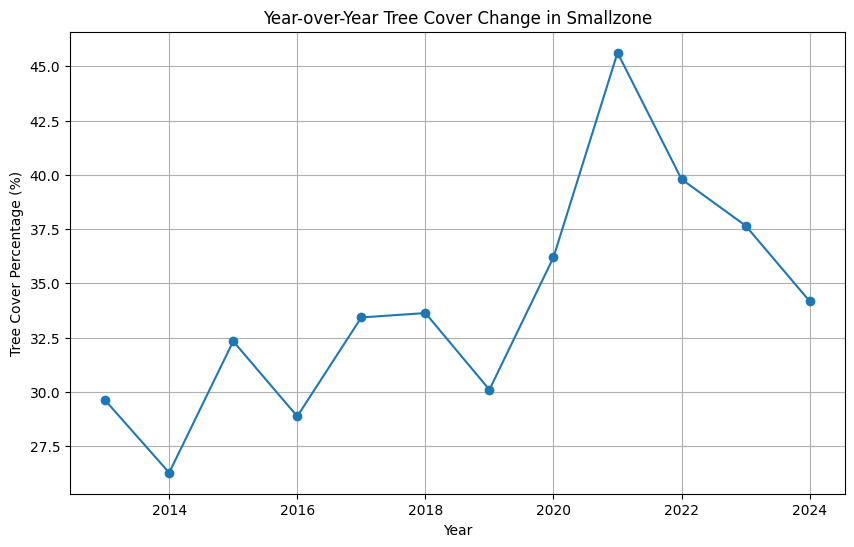

In [ ]:
import matplotlib.pyplot as plt

years = [item['year'] for item in year_percentage_list]
percentages = [item['percentage'] for item in year_percentage_list]

plt.figure(figsize=(10, 6))
plt.plot(years, percentages, marker='o', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Tree Cover Percentage (%)")
plt.title("Year-over-Year Tree Cover Change in Smallzone")
plt.grid(True)
plt.show()

## Summary:

### Data Analysis Key Findings

*   A function was successfully defined to calculate the percentage of tree cover within a geometry from an NDVI image, using an NDVI threshold of 0.3.
*   The tree cover percentage for each year from 2013 to 2024 within the 'smallzone' region was calculated by applying the defined function to the NDVI image collection.
*   The calculated tree cover percentages for each year were successfully extracted into a Python list of dictionaries, with each dictionary containing the year and its corresponding percentage.
*   A line plot was generated showing the year-over-year change in tree cover percentage from 2013 to 2024.

### Insights or Next Steps

*   Analyze the trend in the generated plot to understand the overall change in tree cover in the 'smallzone' over the specified period.
*   Consider investigating potential factors that might be contributing to any observed changes in tree cover, such as urbanization, policy changes, or environmental factors.
